## Library imports

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cvxpy as cp

## Helper Classes

In [11]:
class Circle():
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
        
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def get_r(self):
        return self.r
        
    def draw(self, ax, color):
        circle = plt.Circle((self.x, self.y), self.r, color=color, fill=False)
        ax.add_patch(circle)

class Robot(Circle):
    def __init__(self, x, y, r):
        super().__init__(x, y, r)

class Obstacle(Circle):
    def __init__(self, x, y, r):
        super().__init__(x, y, r)

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def draw(self, ax, color, marker, size):
        ax.scatter(self.x, self.y, c=color, marker=marker, s=size)

## Environment
- The environment is predefined. Obstacle size and positions are known to the robot during planning.
- Obstacles are circular in shape
- The robot is omni-directional (holonomic)

In [15]:
class Env:
    def __init__(self, xmin, xmax, ymin, ymax, goal):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
        self.goal = goal
        self.robot_patch = None
        
        self.obs = []
        self.fig, self.ax = plt.subplots(1, 1, figsize=(15,15))
        
    def gen_obs(self):
        self.obs.append(Circle(40, 60, 10))
        self.obs.append(Circle(80, 90, 7))
        self.obs.append(Circle(15, 30, 7)) 
        
    def draw_env(self):
        self.ax.plot([self.xmin, self.xmin, self.xmax, self.xmax, self.xmin],\
                     [self.ymin, self.ymax, self.ymax, self.ymin, self.ymin],\
                     'k', lw=0.5)
        
        self.goal.draw(self.ax, 'g', 'x', 50)
        
        for obstacle in self.obs:
            obstacle.draw(self.ax, 'r')
            
    def draw_path(self, path):
        
        for waypoints in path:
            waypoints.draw(self.ax, 'b', '.', 30)
            
    def add_title(self, title):
        self.ax.set_title(title, loc='center', fontweight ="bold")

## Problem Statement
The problem is to find out trajectory for an omni directional robot to reach a predefined goal by avoiding obstacles on the path. 

We solve this problem using **Model Predictive Control** which formulates it as an optimisation problem to find velocity control points at each time step.

## Formulation
- We need to find out velocity vectors $ X $ and $ Y $ which consists of n data points each, where $ n $ is the total number of time steps. 
- The initial ($x_0$, $y_0$) and goal ($x_g, y_g$) position of the robot are known.  
- We have constraints to avoid the circular obstacles and contraints on the velocity, threshold such that it does not exceed a given $v_{max}$.

- $ Cost \; Function $ = $ ((x_0 - x_g) + (\dot{x_0} + \dot{x_1} + \dot{x_2} + \dot{x_3} ... \dot{x_{n-1}}) \delta t)^2 + ((y_0 - y_g) + (\dot{y_0} + \dot{y_1} + \dot{y_2} + \dot{y_3} ... \dot{y_{n-1}}) \delta t)^2 $

- We need to minimize the above cost function, which basically tries to minimize the distance between the robot's current position and goal position.

- The above cost function can be converted to quadratic form as $ \hat{X}^TA\hat{X} + q_1^T\hat{X} + C_1 + \hat{Y}^TB\hat{Y} + q_1^T\hat{Y} + C_2 $


In [16]:
class MPC:
    def __init__(self, env, start, goal, timeStep, robot, steps):
        self.env = env
        self.start = start
        self.goal = goal
        self.robot = robot
        self.timeStep = timeStep
        self.steps = steps
        self.path = None
        self._init_var()
        self._gen_cost_function()
        self._solve_opt()
        
    def _init_var(self):
        self.xdot = cp.Variable(steps)
        self.ydot = cp.Variable(steps)
    
    def get_var(self):
        return self.xdot.value, self.ydot.value
    
    def get_path(self):
        
        path = []
        currPoint = start
        
        path.append(currPoint)
        
        for idx in range(len(self.xdot.value)):
            currX = currPoint.get_x() + self.xdot.value[idx] * self.timeStep
            currY = currPoint.get_y() + self.ydot.value[idx] * self.timeStep
            
            currPoint = Point(currX, currY)
            path.append(currPoint)
            
        self.path = path
        
        return self.path
    
    def _gen_cost_function(self):
        A = np.ones((self.steps, self.steps)) * self.timeStep ** 2
        
        oneVec = np.ones(self.steps)
        
        q1 = 2 * (start.get_x() - goal.get_x()) * self.timeStep * oneVec
        q2 = 2 * (start.get_y() - goal.get_y()) * self.timeStep * oneVec 
        
        c1 = (start.get_x() - goal.get_x()) ** 2
        c2 = (start.get_y() - goal.get_y()) ** 2
        
        cost_fn_x = cp.quad_form(self.xdot, A) + q1.T @ self.xdot + c1
        cost_fn_y = cp.quad_form(self.ydot, A) + q2.T @ self.ydot + c2
        
        self.cost_fn = cost_fn_x + cost_fn_y
        
    def _solve_opt(self):
        prob = cp.Problem(cp.Minimize(self.cost_fn))
        prob.solve()
        
        

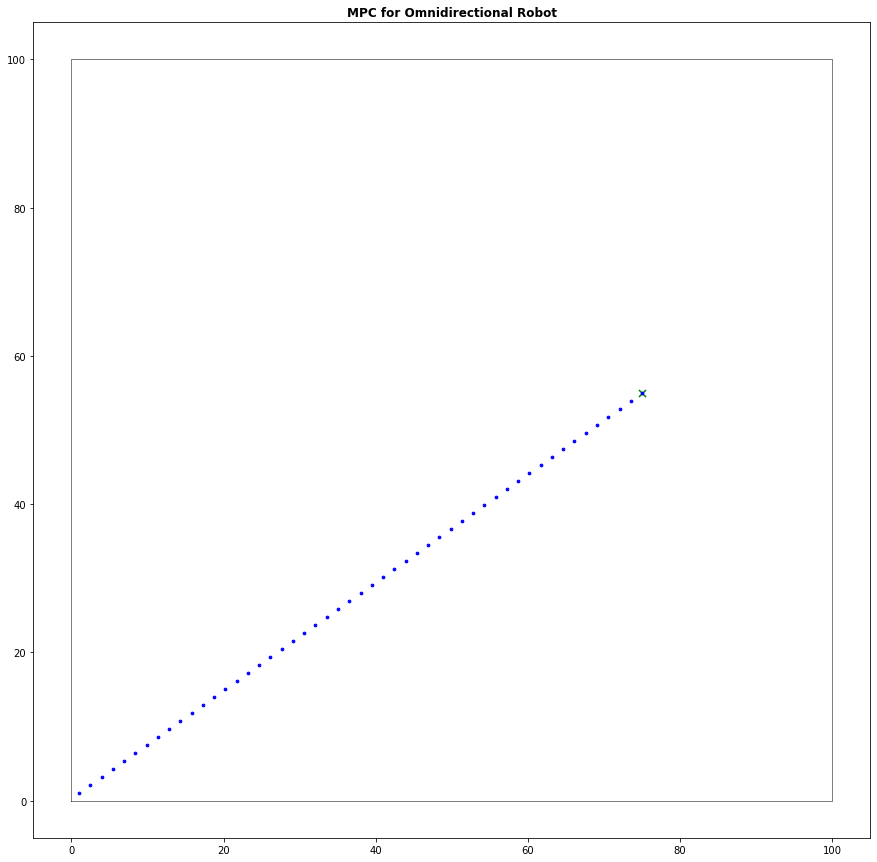

In [18]:
if __name__ == '__main__':
    
    gridStartX = 0 
    gridStartY = 0
    
    gridEndX = 100 
    gridEndY = 100
    robotRadius = 1
    timeStep = 0.1
    
    steps = 50
    
    start = Point(1, 1) 
    
    goal = Point(75, 55) 
    
    robot = Robot(start.get_x(), start.get_y(), robotRadius)
    
    env = Env(gridStartX, gridEndX, gridStartY, gridEndY, goal)

    env.add_title('MPC for Omnidirectional Robot')
    env.draw_env()

    mpc = MPC(env, start, goal, timeStep, robot, steps)
    
    path = mpc.get_path()
    
    env.draw_path(path)
    
    xdot, ydot = mpc.get_var()